# Описание

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Условие успешного выполнения задачи: `добиться MAE ниже 8`

# Импорты и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('notebook', rc={'figure.figsize':(14, 7)})
plt.style.use('fivethirtyeight')

SEED = 69
PATH = '/datasets/faces/'
IMAGE_DIR = PATH + 'final_files/'

In [2]:
# загрузка CSV файла
df = pd.read_csv(PATH + 'labels.csv')

print(f'Размер выборки: {df.shape}')

Размер выборки: (7591, 2)


In [3]:
def load_data(df, path):
    # Train datagenerator
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255.)
    # Validation datagenerator
    valid_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255.)
    # Train datagenerator
    train_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                   directory=path,
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   class_mode='raw',
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   subset='training',
                                                   seed=SEED)
    # Validation datagenerator
    valid_flow = valid_datagen.flow_from_dataframe(dataframe=df,
                                                   directory=path,
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   class_mode='raw',
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   subset='validation',
                                                   seed=SEED)
    return train_flow, valid_flow

In [4]:
train_flow, valid_flow = load_data(df, IMAGE_DIR)

# Из обучающей выборки
X, y = next(train_flow)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


# Анализ

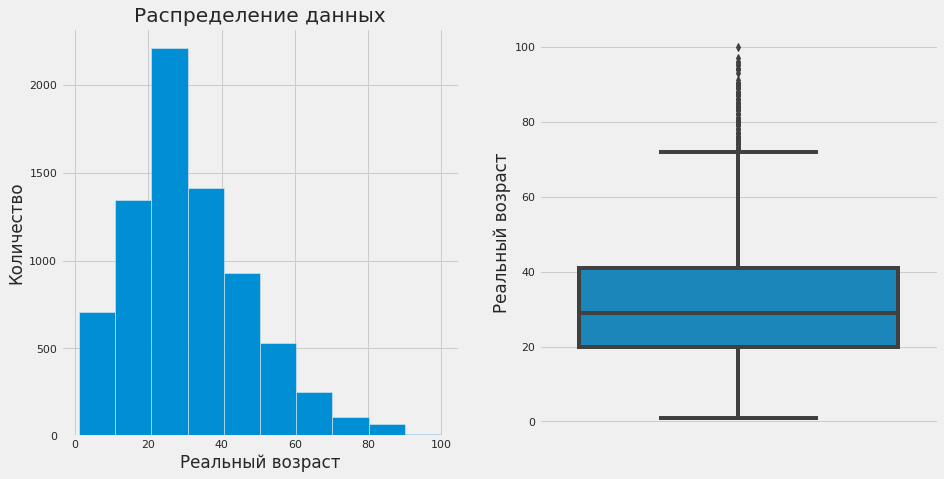

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

df['real_age'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Распределение данных')
ax[0].set_ylabel('Количество')
ax[0].set_xlabel('Реальный возраст')

sns.boxplot(data=df, y='real_age', ax=ax[1])
ax[1].set_ylabel('Реальный возраст')

plt.show()

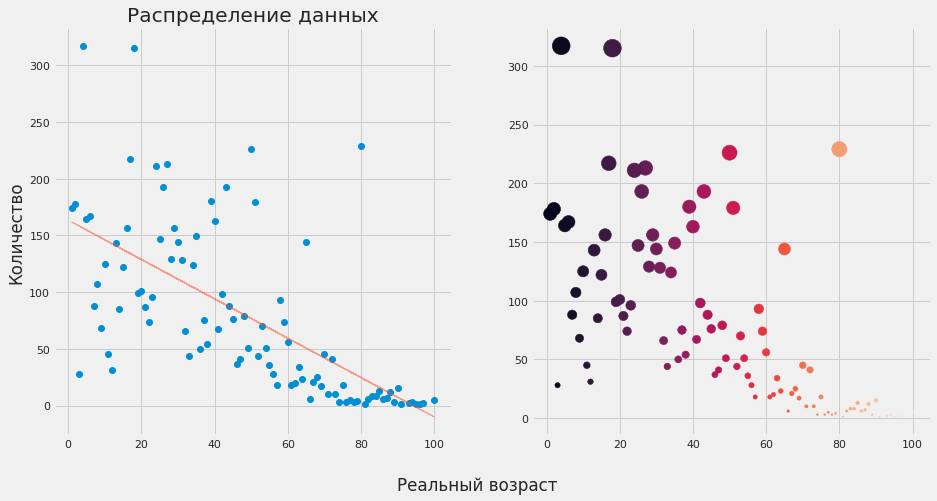

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

x = np.array(df['real_age'].unique())
y = np.array(df['real_age'].value_counts())
m, b = np.polyfit(x, y, 1)

fig.suptitle('Реальный возраст', y=-0.01)

ax[0].plot(x, y, 'o')
ax[0].plot(x, m*x+b, linewidth=1, alpha=.5)
ax[0].set_title('Распределение данных')
ax[0].set_ylabel('Количество')

ax[1].scatter(x, y, c=x, s=y)

plt.show()

Данные в порядке, на графике с усами можно заметить небольшое количество выбросов. Это нормально - пожилых людей как правило меньше. Как правило - модель не должна обучаться на "сильно очищенных" данных от выбросов, т.к. в тестовой выборке (которая как правило будет неизвестна) выбросы, скорее всего будут.

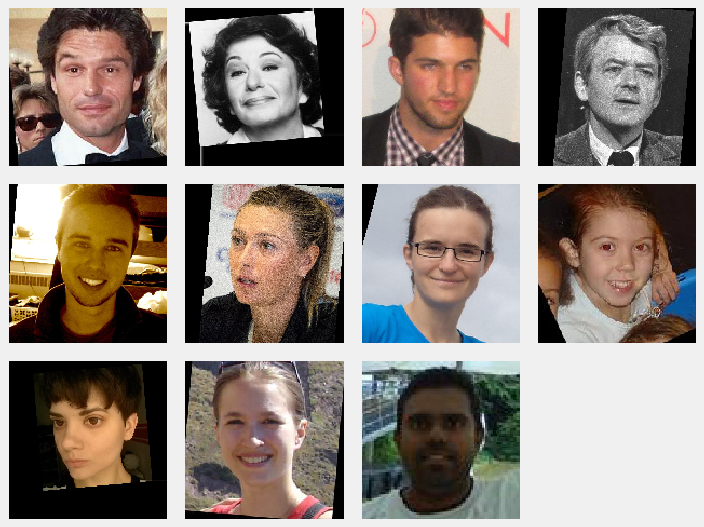

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(11):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(X[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

По визуализированой выборке можно сделать такой вывод: Изображения с которыми мы работаем предобработаны. Это объясняет фокусировка кадра на конкретном лице! Так же наши изображения разного размера и некоторые из изображений обводятся черной рамкой. Плохо это или хорошо - не могу точно сказать, т.к. фокусировка всё равно остаётся на лице. 

# Обучение модели

(Код в этом разделе запускался в отдельном GPU-ноутбуке, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError


def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255.)
    train_data = train_datagen.flow_from_dataframe(
        dataframe = labels, 
        directory = path + 'final_files/', 
        x_col='file_name', y_col='real_age', 
        subset = 'training', 
        target_size = (150, 150), 
        batch_size = 32, 
        class_mode='raw', 
        seed=12345)
    
    return train_data

def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255.)
    test_data = test_datagen.flow_from_dataframe(
        dataframe = labels, 
        directory = path + 'final_files/', 
        x_col='file_name', y_col='real_age', 
        subset = 'validation', 
        target_size = (150, 150), 
        batch_size = 32, 
        class_mode='raw', 
        seed=12345)
    
    return test_data

def create_model(input_shape):
    
    optimizer = Adam(lr=0.00001)
    backbone=ResNet50(input_shape=input_shape, weights = 'imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=73, 
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, validation_data=test_data, steps_per_epoch=steps_per_epoch, 
              validation_steps = validation_steps,
             verbose=1, epochs=epochs, batch_size=batch_size)
    return model

```

```

60/60 - 9s - loss: 79.9751 - mae: 6.7900

Test MAE: 6.7900


```

Я сравнивал две архитектуры: LeNet и ResNet50, где ResNet50 была явным фаворитом. LeNet останавливалась на показателе MAE = 14.xxx и не опускалась ниже. Возможно такой результат получен из за недостаточного количества полносвязных слоёв вверху архитектуры модели. ResNet50 использовалась стандартная предобученная архитектура на данных "imagenet". Результат MAE ResNet50 показала лучше, чем я ожидал. Предполагаю, что можно получить MAE гораздо лучше, если использовать изображения одного размера без черной обводки.

# Анализ обученной модели

Чтобы получить такой результат я использовал предобученную архитектуру ResNet50 на данных imagenet. Модель превзошла мои ожидания. Средняя абсолютная ошибка ниже 7, что является отличным результатом по условиям задачи. Модели понадобилось 73 эпохи, а параметр learning rate оптимизатора Adam равен 1e-5.